# **Seasonal Forecasting**

This notebook is adapted from the AI for Earth System Science Hackathon 2020 written by Ankur Mahesh (ClimateAi)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install netCDF4

## Introduction


El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we will issue ENSO forecasts using machine learning, which uses statistical optimization to issue forecasts.






## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [ ]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [ERA 2-meter temperature anomlay](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.
*   CNRM-CM5 pre-industrial control run climate model surface temperature
*   Max Planck Institute CMIP5 pre-industrial control run surface temperature

More information about the climate models can be found [here](https://esgf-node.llnl.gov/projects/cmip5/).

The pre-industrial control runs are climate model scenarios that assume that there are no anthropogenic emissions. The reason that we use the "pre-industrial control" run of the climate models as opposed to the historical runs is that the former runs are far longer, allowing us to have more data for neural network training.

### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Data wrangling

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('/content/drive/My Drive/Colab Notebooks/content/nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('/content/drive/My Drive/Colab Notebooks/content/sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  print(len(y), len(predictions))
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


In [ ]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


# Regression

The baseline ML model will be linear regression. It is also possible to use ridge regression.
Does variance scaling help with the task? (Hint: sklearn.preprocessing StandardScaler)

RMSE: 0.28
120 120


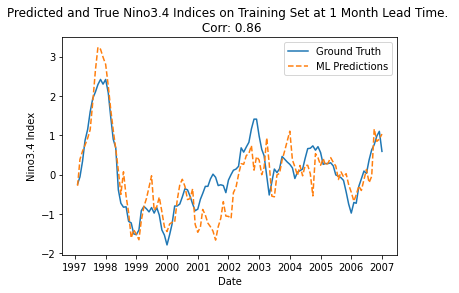

In [ ]:
#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Deep Learning

Now let's try training a neural network to forecast ENSO.  Makes use of Pytorch



Let's get started: first, let's load the data.  **PLEASE READ THE DOCSTRING FOR THE `assemble_predictors_predictands` function!** It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In this section, the `assemble_predictors_predictands` method has been extended to load in data from observations AND from GCMs.

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('/content/drive/My Drive/Colab Notebooks/content/nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date 
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an 
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each 
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use 
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : '/content/drive/My Drive/Colab Notebooks/content/sst.mon.mean.trefadj.anom.1880to2018.nc',
               'observations2': '/content/drive/My Drive/Colab Notebooks/content/regridded_era_t2m_anomalies.nc',
               'CNRM'         : '/content/drive/My Drive/Colab Notebooks/content/CNRM_tas_anomalies_regridded.nc',
               'MPI'          : '/content/drive/My Drive/Colab Notebooks/content/MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'observations2': 't2m',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    try:
        sst=sst.sel(lat=lat_slice)
    except:
        raise NotImplementedError("Implement slicing!")
  if lon_slice is not None:
    try:
        sst=sst.sel(lon=lon_slice)
    except:
        raise NotImplementedError("Implement slicing!")
  
  
  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)
    

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead, 
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]


class ENSODatasetSeriesMode(Dataset):
    def __init__(self, enso_dataset, series_length=10):
        self.predictors = enso_dataset.predictors
        self.predictands = enso_dataset.predictands
        self.series_length = series_length
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"
        
    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        series_length = self.series_length
        if idx < series_length - 1:
            return np.array(self.predictors[:idx+1]), np.array(self.predictands[:idx+1])
        else:
            return np.array(self.predictors[idx-series_length+1:idx+1]), np.array(self.predictands[idx-series_length+1:idx+1])

**IMPORTANT info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


## A Simple Convolutional Neural Network to Forecast ENSO


Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_input_time_steps=1, batch_size=6, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, batch_size, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(batch_size, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(64, 1)

        self.lstm = nn.LSTM(input_size=84, hidden_size=64, num_layers=2)

        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = x[0]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = x.view([-1, 1, 84])
        x,_ = self.lstm(x)
        x = self.fc3(x)
        
        return x

class CNN_mine(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN_mine, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 64, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 64, 5, padding=2)
        self.dropout = nn.Dropout(p=0.5)
        self.dropout2d = nn.Dropout2d(p=0.5)
        
        self.fc1 = nn.Linear(64 * 990, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2d(self.pool(F.relu(self.conv3(x))))
        x = x.view(-1, 64 * 990)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

**IMPORTANT** Reading through this method will help you understand each step in the process of training a neural network!

In [ ]:
tester = False
trainer = False

def train_network(net, criterion, optimizer, trainloader, testloader, 
                  experiment_name, num_epochs=40, classification=False, file_name='1'):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()
          global tester, trainer
          if tester == False and mode == 'test':
              tester = True
              print(predictions.size(), batch_predictors.size())
              print(predictions, batch_predictands.squeeze())
              print(criterion(predictions, batch_predictands.squeeze()).item())
          if trainer == False and mode == 'train':
              trainer = True
              print(predictions.size(), batch_predictors.size())
              print(predictions, batch_predictands.squeeze())
              print(criterion(predictions, batch_predictands.squeeze()).item())

          

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands.squeeze())

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}{}.pt'.format(file_name, experiment_name))
      #if epoch % 10 == 9:
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}{}.pt'.format(file_name, experiment_name), map_location='cpu')
  net.eval()
  net.to(device)
  #print("best loss {}".format(best_loss))
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = []
  c = 0
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)
    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions += list(batch_predictions.detach().cpu().numpy())
  predictions = np.asarray(predictions)
  if classification == True:
    predictions = np.where(predictions<=0, 0, predictions) 
    predictions = np.where(predictions>0, 1, predictions)
  return predictions, train_losses, test_losses

In [ ]:
mode = "CNN"

In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
if False:
  train_start_date = '1860-01-01'
  train_end_date = '2005-12-31'
  num_input_time_steps = 2
  for lead_time in range(4, 13):
    print('-'*30)
    print('With lead time {}'.format(lead_time))
    sequence_length = 10
    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, 'MPI', 'spatial', num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('1981-01-01',
                        '2010-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

    #Convert the numpy ararys into ENSODataset, which is a subset of the 
    #torch.utils.data.Dataset class.  This class is compatible with
    #the torch dataloader, which allows for data loading for a CNN
    #train_dataset = ENSODataset(train_predictors, train_predictands)
    #test_dataset = ENSODataset(test_predictors, test_predictands)
    train_series_dataset = ENSODatasetSeriesMode(train_dataset, series_length=sequence_length)
    test_series_dataset = ENSODatasetSeriesMode(test_dataset, series_length=sequence_length)
    #print(len(train_dataset))

    #Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
    #the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
    #trainloader = DataLoader(train_dataset, batch_size=10)
    trainloader = DataLoader(train_series_dataset, batch_size=1)
    #testloader = DataLoader(test_dataset, batch_size=10)
    testloader = DataLoader(test_series_dataset, batch_size=1)

    net = CNN_LSTM(num_input_time_steps=num_input_time_steps)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
    predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                      optimizer, trainloader, testloader, experiment_name, file_name="{}".format(lead_time))
    print(test_predictands, predictions)
    print(len(test_predictands), len(predictions))
    corr, _ = pearsonr(test_predictands, predictions)
    rmse = mean_squared_error(test_predictands, predictions) ** 0.5
    print(corr, rmse)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
    plt.legend(loc='best')
    plt.show()
    test_predictands, predictions

    corr, _ = pearsonr(test_predictands, predictions)
    rmse = mean_squared_error(test_predictands, predictions) ** 0.5

    #plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
    #                                                                    corr, rmse))

------------------------------
Lead Time: 5, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
torch.Size([16]) torch.Size([16, 2, 180, 360])
tensor([ 0.1714,  0.1468,  0.1812,  0.1400,  0.0794,  0.0378,  0.0509, -0.0023,
         0.0562,  0.1393,  0.2011,  0.1072,  0.1202,  0.1545,  0.1361,  0.1103],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([ 0.4361,  0.6444,  0.8604,  0.9447,  1.0955,  1.1621,  1.2863,  1.2609,
         1.1233,  0.9716,  0.8205,  0.5045, -0.0842, -0.4666, -0.6813, -0.5467],
       device='cuda:0')
0.6715792417526245
train Set: Epoch 01. loss: 0.634697
torch.Size([16]) torch.Size([16, 2, 180, 360])
tensor([0.0247, 0.0251, 0.0207, 0.0206, 0.0236, 0.0219, 0.0185, 0.0231, 0.0266,
        0.0245, 0.0249, 0.0263, 0.0291, 0.0301, 0.0352, 0.0404],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([-0.4300, -0.1800, -0.0700, -0.0300, -0.2700,  0.0700, -0.0400, -0.1300,
        -0.0200,  0.2400,  0.6500,  0.9200,  0.6400,  0.9300,  1.3900,  2.0000],
       device='cuda:0')
0.5294771790504456
test Set: Epoch 01. loss: 0.821047
train S

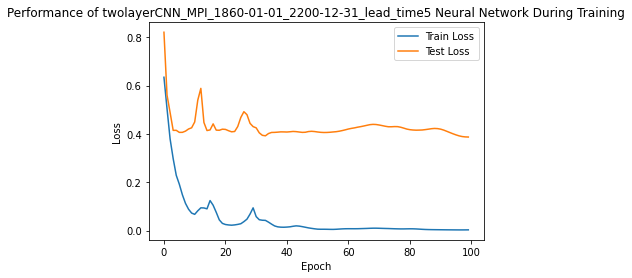

0.7331613399997705 0.6266831146357672
------------------------------
Lead Time: 6, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.631775
test Set: Epoch 01. loss: 0.824965
train Set: Epoch 02. loss: 0.596109
test Set: Epoch 02. loss: 0.776392
train Set: Epoch 03. loss: 0.503801
test Set: Epoch 03. loss: 0.599681
train Set: Epoch 04. loss: 0.374004
test Set: Epoch 04. loss: 0.518872
train Set: Epoch 05. loss: 0.304468
test Set: Epoch 05. loss: 0.531667
train Set: Epoch 06. loss: 0.284837
test Set: Epoch 06. loss: 0.515795
train Set: Epoch 07. loss: 0.279148
test Set: Epoch 07. loss: 0.479918
train Set: Epoch 08. loss: 0.280364
test Set: Epoch 08. loss: 0.526088
train Set: Epoch 09. loss: 0.240272
test Set: Epoch 09. loss: 0.594259
train Set: Epoch 10. loss: 0.194862
test Set: Epoch 10. loss: 0.611911
train Set: Epoch 11. loss: 0.137178
test Set: Epoch 11. loss: 0.600009
train Set: Epoch 12. loss: 0.108656
test Set: Epoch 12. loss: 0.619035
train Set: Epoch 13. loss: 0.090674
test Set: Epoch 13. loss: 0.623798
train Set: Epoch 14. loss: 0.086109
test Set: Epoch 14. loss: 0.554

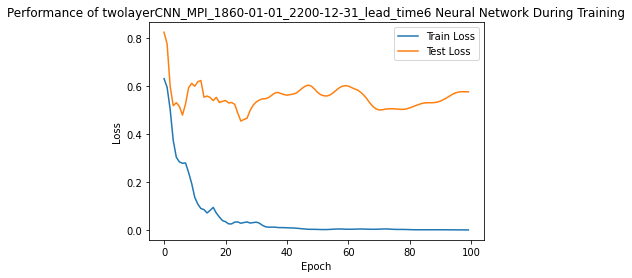

0.66513310892092 0.6775282620591563
------------------------------
Lead Time: 7, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.632421
test Set: Epoch 01. loss: 0.831055
train Set: Epoch 02. loss: 0.615431
test Set: Epoch 02. loss: 0.812673
train Set: Epoch 03. loss: 0.567102
test Set: Epoch 03. loss: 0.704289
train Set: Epoch 04. loss: 0.466518
test Set: Epoch 04. loss: 0.595070
train Set: Epoch 05. loss: 0.376503
test Set: Epoch 05. loss: 0.582616
train Set: Epoch 06. loss: 0.322061
test Set: Epoch 06. loss: 0.570105
train Set: Epoch 07. loss: 0.308590
test Set: Epoch 07. loss: 0.561517
train Set: Epoch 08. loss: 0.267959
test Set: Epoch 08. loss: 0.566983
train Set: Epoch 09. loss: 0.269953
test Set: Epoch 09. loss: 0.584259
train Set: Epoch 10. loss: 0.261969
test Set: Epoch 10. loss: 0.563104
train Set: Epoch 11. loss: 0.222960
test Set: Epoch 11. loss: 0.533811
train Set: Epoch 12. loss: 0.196794
test Set: Epoch 12. loss: 0.523694
train Set: Epoch 13. loss: 0.191582
test Set: Epoch 13. loss: 0.561151
train Set: Epoch 14. loss: 0.175029
test Set: Epoch 14. loss: 0.557

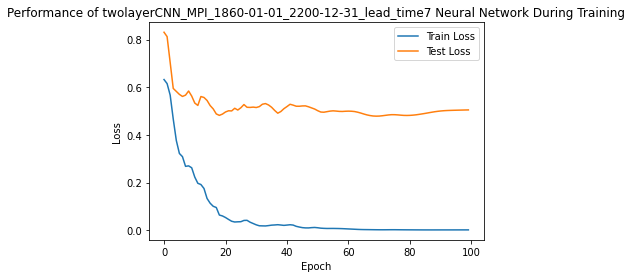

0.639875874183325 0.6964229973894842
------------------------------
Lead Time: 8, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.624162
test Set: Epoch 01. loss: 0.810964
train Set: Epoch 02. loss: 0.589397
test Set: Epoch 02. loss: 0.778522
train Set: Epoch 03. loss: 0.502682
test Set: Epoch 03. loss: 0.681656
train Set: Epoch 04. loss: 0.405299
test Set: Epoch 04. loss: 0.611325
train Set: Epoch 05. loss: 0.333709
test Set: Epoch 05. loss: 0.587152
train Set: Epoch 06. loss: 0.277748
test Set: Epoch 06. loss: 0.563845
train Set: Epoch 07. loss: 0.225711
test Set: Epoch 07. loss: 0.544061
train Set: Epoch 08. loss: 0.173371
test Set: Epoch 08. loss: 0.551239
train Set: Epoch 09. loss: 0.169618
test Set: Epoch 09. loss: 0.562248
train Set: Epoch 10. loss: 0.221695
test Set: Epoch 10. loss: 0.568239
train Set: Epoch 11. loss: 0.245688
test Set: Epoch 11. loss: 0.563306
train Set: Epoch 12. loss: 0.203638
test Set: Epoch 12. loss: 0.528297
train Set: Epoch 13. loss: 0.171800
test Set: Epoch 13. loss: 0.503483
train Set: Epoch 14. loss: 0.119409
test Set: Epoch 14. loss: 0.518

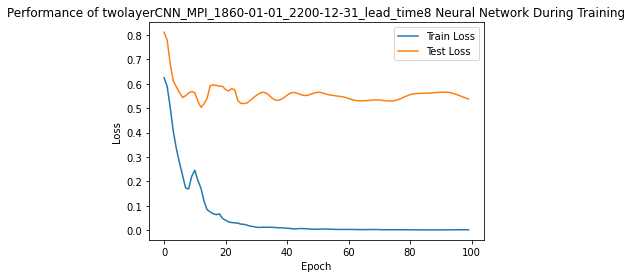

0.6476284452452634 0.7166537108100425
------------------------------
Lead Time: 9, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.624190
test Set: Epoch 01. loss: 0.809911
train Set: Epoch 02. loss: 0.598916
test Set: Epoch 02. loss: 0.799632
train Set: Epoch 03. loss: 0.541986
test Set: Epoch 03. loss: 0.764771
train Set: Epoch 04. loss: 0.459070
test Set: Epoch 04. loss: 0.677049
train Set: Epoch 05. loss: 0.414926
test Set: Epoch 05. loss: 0.660458
train Set: Epoch 06. loss: 0.374939
test Set: Epoch 06. loss: 0.637464
train Set: Epoch 07. loss: 0.328897
test Set: Epoch 07. loss: 0.661549
train Set: Epoch 08. loss: 0.292955
test Set: Epoch 08. loss: 0.643098
train Set: Epoch 09. loss: 0.251249
test Set: Epoch 09. loss: 0.583656
train Set: Epoch 10. loss: 0.234027
test Set: Epoch 10. loss: 0.620150
train Set: Epoch 11. loss: 0.241743
test Set: Epoch 11. loss: 0.642469
train Set: Epoch 12. loss: 0.214619
test Set: Epoch 12. loss: 0.544667
train Set: Epoch 13. loss: 0.226152
test Set: Epoch 13. loss: 0.580409
train Set: Epoch 14. loss: 0.134601
test Set: Epoch 14. loss: 0.545

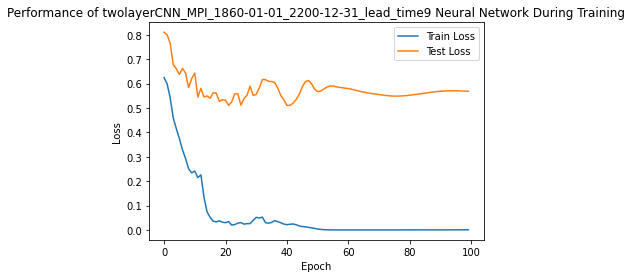

0.6362746835275782 0.7212582649537537
------------------------------
Lead Time: 10, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.604866
test Set: Epoch 01. loss: 0.769923
train Set: Epoch 02. loss: 0.544568
test Set: Epoch 02. loss: 0.737045
train Set: Epoch 03. loss: 0.463713
test Set: Epoch 03. loss: 0.717273
train Set: Epoch 04. loss: 0.398942
test Set: Epoch 04. loss: 0.699913
train Set: Epoch 05. loss: 0.345628
test Set: Epoch 05. loss: 0.658479
train Set: Epoch 06. loss: 0.298296
test Set: Epoch 06. loss: 0.640354
train Set: Epoch 07. loss: 0.252040
test Set: Epoch 07. loss: 0.624763
train Set: Epoch 08. loss: 0.229011
test Set: Epoch 08. loss: 0.620190
train Set: Epoch 09. loss: 0.219558
test Set: Epoch 09. loss: 0.582210
train Set: Epoch 10. loss: 0.269039
test Set: Epoch 10. loss: 0.606240
train Set: Epoch 11. loss: 0.193953
test Set: Epoch 11. loss: 0.609063
train Set: Epoch 12. loss: 0.186737
test Set: Epoch 12. loss: 0.603753
train Set: Epoch 13. loss: 0.166714
test Set: Epoch 13. loss: 0.625487
train Set: Epoch 14. loss: 0.103470
test Set: Epoch 14. loss: 0.621

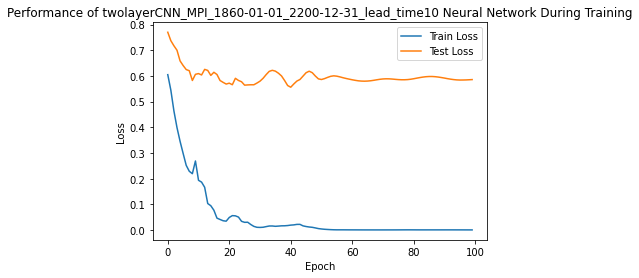

0.5788996189682853 0.7518443239443636
------------------------------
Lead Time: 11, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.623562
test Set: Epoch 01. loss: 0.821227
train Set: Epoch 02. loss: 0.584120
test Set: Epoch 02. loss: 0.804268
train Set: Epoch 03. loss: 0.523459
test Set: Epoch 03. loss: 0.753536
train Set: Epoch 04. loss: 0.435498
test Set: Epoch 04. loss: 0.743674
train Set: Epoch 05. loss: 0.402567
test Set: Epoch 05. loss: 0.749723
train Set: Epoch 06. loss: 0.394830
test Set: Epoch 06. loss: 0.742739
train Set: Epoch 07. loss: 0.343136
test Set: Epoch 07. loss: 0.720381
train Set: Epoch 08. loss: 0.321977
test Set: Epoch 08. loss: 0.699545
train Set: Epoch 09. loss: 0.293628
test Set: Epoch 09. loss: 0.692409
train Set: Epoch 10. loss: 0.249316
test Set: Epoch 10. loss: 0.671902
train Set: Epoch 11. loss: 0.234587
test Set: Epoch 11. loss: 0.672163
train Set: Epoch 12. loss: 0.207630
test Set: Epoch 12. loss: 0.674169
train Set: Epoch 13. loss: 0.198516
test Set: Epoch 13. loss: 0.651543
train Set: Epoch 14. loss: 0.161428
test Set: Epoch 14. loss: 0.631

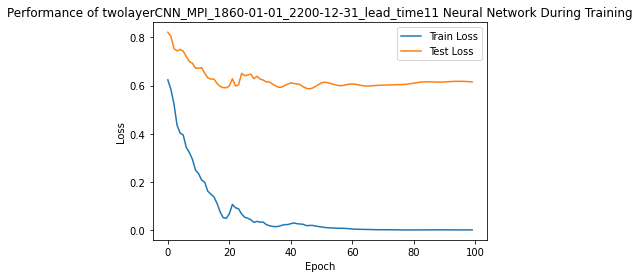

0.5361349190171839 0.7696170662214974
------------------------------
Lead Time: 12, Num imput time steps: 2


/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


1
Finish 
train Set: Epoch 01. loss: 0.622160
test Set: Epoch 01. loss: 0.823642
train Set: Epoch 02. loss: 0.587529
test Set: Epoch 02. loss: 0.815659
train Set: Epoch 03. loss: 0.532482
test Set: Epoch 03. loss: 0.776591
train Set: Epoch 04. loss: 0.469274
test Set: Epoch 04. loss: 0.753794
train Set: Epoch 05. loss: 0.426256
test Set: Epoch 05. loss: 0.756659
train Set: Epoch 06. loss: 0.418494
test Set: Epoch 06. loss: 0.744165
train Set: Epoch 07. loss: 0.408477
test Set: Epoch 07. loss: 0.727785
train Set: Epoch 08. loss: 0.382754
test Set: Epoch 08. loss: 0.726040
train Set: Epoch 09. loss: 0.324016
test Set: Epoch 09. loss: 0.699134
train Set: Epoch 10. loss: 0.263433
test Set: Epoch 10. loss: 0.705487
train Set: Epoch 11. loss: 0.206075
test Set: Epoch 11. loss: 0.647134
train Set: Epoch 12. loss: 0.170747
test Set: Epoch 12. loss: 0.647741
train Set: Epoch 13. loss: 0.146564
test Set: Epoch 13. loss: 0.646407
train Set: Epoch 14. loss: 0.142155
test Set: Epoch 14. loss: 0.669

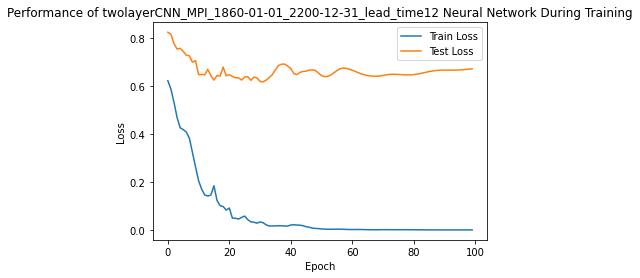

0.5289369806096028 0.7881614525976707


In [ ]:
train_start_date = '1860-01-01'
train_end_date = '2010-12-31'
num_input_time_steps = 2
for lead_time in range(5, 13):
  
      print('-'*30)
      print("Lead Time: {}, Num imput time steps: {}".format(lead_time, num_input_time_steps))
      train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, 'CNRM', 'spatial', num_input_time_steps=num_input_time_steps)
      test_predictors, test_predictands = assemble_predictors_predictands('1981-01-01',
                          '2010-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

      print("1")
      #Convert the numpy ararys into ENSODataset, which is a subset of the 
      #torch.utils.data.Dataset class.  This class is compatible with
      #the torch dataloader, which allows for data loading for a CNN
      train_dataset = ENSODataset(train_predictors, train_predictands)
      test_dataset = ENSODataset(test_predictors, test_predictands)

      #Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
      #the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
      print("Finish ")

      trainloader = DataLoader(train_dataset, batch_size=16)
      testloader = DataLoader(test_dataset, batch_size=16)
      net = CNN(num_input_time_steps=num_input_time_steps)
      optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
      #optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
      #scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma = 0.95)

      experiment_name = "twolayerCNN_MPI_1860-01-01_2200-12-31_lead_time{}".format(lead_time)
      predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                      optimizer, trainloader, testloader, experiment_name, 
                      file_name="",
                      num_epochs=100) 

      plt.plot(train_losses, label='Train Loss')
      plt.plot(test_losses, label='Test Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
      plt.legend(loc='best')
      plt.show()

      corr, _ = pearsonr(test_predictands, predictions)
      rmse = mean_squared_error(test_predictands, predictions) ** 0.5
      print(corr, rmse)

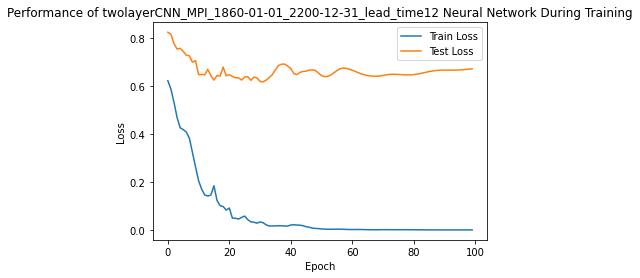

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

0.5289369806096028 0.7881614525976707
359 359


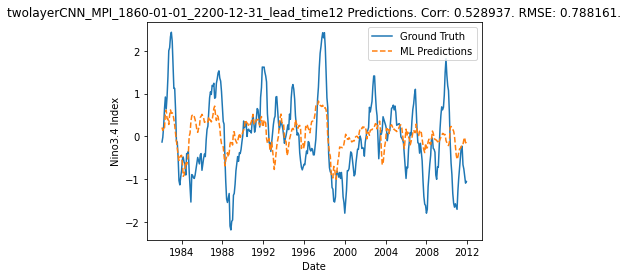

In [ ]:
test_predictands, predictions

corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
print(corr, rmse)

plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

## Using GCMs input

With simulated data, neural networks are able to see more data and thus learn better. The cell below shows how to use xarray

In [ ]:
# time for the GCM MPI data
ds_mpi = xr.open_dataset('/content/drive/My Drive/Colab Notebooks/content/MPI_tas_anomalies_regridded.nc')
ds_mpi

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12000)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2849-12-01 00:00:00
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
Data variables:
    tas      (time, lat, lon) float64 ...

In [ ]:
# Time for the GCM CNRM data
ds_cnrm = xr.open_dataset('/content/drive/My Drive/Colab Notebooks/content/CNRM_tas_anomalies_regridded.nc')
ds_cnrm['time']

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


<xarray.DataArray 'time' (time: 10200)>
array([cftime.DatetimeGregorian(1850, 1, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1850, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(1850, 3, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeGregorian(2699, 10, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2699, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeGregorian(2699, 12, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2699-12-01 00:00:00

In [ ]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1860-01-01'
train_end_date = '2200-12-31'
num_input_time_steps = 2
lead_time = 2
climate_model = 'MPI'


train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, climate_model, 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name,
                  num_epochs=10)

/usr/local/lib/python3.6/dist-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.235966
test Set: Epoch 01. loss: 0.282840
train Set: Epoch 02. loss: 0.071860
test Set: Epoch 02. loss: 0.213493
train Set: Epoch 03. loss: 0.047226
test Set: Epoch 03. loss: 0.203720
train Set: Epoch 04. loss: 0.034699
test Set: Epoch 04. loss: 0.198951
train Set: Epoch 05. loss: 0.027232
test Set: Epoch 05. loss: 0.191328
train Set: Epoch 06. loss: 0.024474
test Set: Epoch 06. loss: 0.188966
train Set: Epoch 07. loss: 0.029802
test Set: Epoch 07. loss: 0.198390
train Set: Epoch 08. loss: 0.051868
test Set: Epoch 08. loss: 0.277564
train Set: Epoch 09. loss: 0.046035
test Set: Epoch 09. loss: 0.228963
train Set: Epoch 10. loss: 0.028218
test Set: Epoch 10. loss: 0.231695
